#### Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd '/content/drive/MyDrive/FYP/Project/Neural network'

/content/drive/MyDrive/FYP/Project/Neural network


### Dataset Loading

In [ ]:
!pip install torchinfo

In [ ]:
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

from torch import nn
import torch.optim as optim
from torchinfo import summary

In [ ]:
df = pd.read_csv('data_preprocessed.csv')

In [ ]:
# split train test set
from sklearn.model_selection import train_test_split

y = df[df.columns[-1]]
X = df.drop(df.columns[-1], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

#### Dataloader

In [ ]:
from torch.utils.data import DataLoader, Dataset

In [ ]:
class MyDataset(Dataset):
  def __init__(self, data, labels):
    self.data = data
    self.labels = labels

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    # Get data and label from your dataframe
    data = torch.tensor(self.data.iloc[idx].to_numpy(), requires_grad=True, dtype=torch.float32)# Replace with your feature columns
    label = torch.tensor(self.labels.iloc[idx], requires_grad=True, dtype=torch.float32)  # Replace with your label column

    return data, label


In [ ]:
trainset = MyDataset(X_train, y_train)
testset = MyDataset(X_test, y_test)

In [ ]:
trainloader = DataLoader(trainset, 128, True)
testloader = DataLoader(testset, 128, True)

#### Helper function

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def evaluate_acc(net, dataloader):
  net.eval()
  inputs, labels = next(iter(dataloader))

  inputs = inputs.to(device)
  labels = labels.to(device)

  with torch.no_grad():
    running_corrects = 0
    outputs = net(inputs)
    predicted = outputs.ravel() >= 0.5
    running_corrects += (labels == predicted).double().sum()

  acc = running_corrects/len(labels)

  labels = labels.reshape(-1, 1).float()
  with torch.no_grad():
    loss = F.binary_cross_entropy(outputs, labels)

  return acc.to('cpu'), loss.item()

In [ ]:
# train function

def train(net, trainloader=trainloader, testloader=testloader, device=device, num_epochs=15, lr=0.1, momentum=0.9, verbose=False):
  loss_iterations = int(np.ceil(len(trainloader)/3))

  # transfer to model to GPU
  net = net.to(device)

  # optimizer
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

  # set to training mode
  # net.train()

  # variables
  best_loss = np.inf
  saturated_count = 0

  history = {'iter' : [], 'training_cost': [], 'testing_cost': [], 'acc_train' : [], 'acc_val' : [] }

  # train network
  for e in range(num_epochs):

    net.train()
    running_loss = 0
    running_count = 0

    epoch_loss = 0
    epoch_count = 0

    for i, (inputs, labels) in enumerate(trainloader):

      labels = labels.reshape(-1, 1).float()

      # clear gradient to zero
      optimizer.zero_grad()

      # transfer data to GPU
      inputs = inputs.to(device)
      labels = labels.to(device)

      # forward prop
      outs = net(inputs)

      # compute loss
      loss = F.binary_cross_entropy(outs, labels)

      # backprop
      loss.backward()

      # update params
      optimizer.step()

      # get the loss of training
      running_loss += loss.item()
      running_count += 1

      epoch_loss += loss.item()
      epoch_count += 1

      # display the averaged loss value
      if i % loss_iterations == loss_iterations-1 or i == len(trainloader) - 1:
        train_loss = running_loss / running_count
        running_loss = 0.
        running_count = 0.

        if verbose:
          print(f'[Epoch {e+1:2d} Iter {i+1:5d}/{len(trainloader)}]: train_loss = {train_loss:.4f}')

    train_acc, train_loss = evaluate_acc(net, trainloader)
    test_acc, test_loss = evaluate_acc(net, testloader)

    if verbose:
      print(f'Train acc: {train_acc:.4f}')
      print(f'Test acc: {test_acc:.4f}\n')

    # store cost

    history['training_cost'].append(epoch_loss/epoch_count)
    epoch_loss = 0
    epoch_count = 0

    history['testing_cost'].append(test_loss)

    # Compute the training and validation accuracy
    history['iter'].append(e)

    acc_train, _ = evaluate_acc(net, trainloader)
    history['acc_train'].append(acc_train)

    acc_val, _ = evaluate_acc(net, testloader)
    history['acc_val'].append(acc_val)

  return history


In [ ]:
# evaluate function

def evaluate(net, dataloader, device=device):
  # set to eval mode
  net.eval()

  running_corrects = 0

  # repeat for all batch data in test set
  for inputs, targets in dataloader:
    inputs = inputs.to(device)
    targets = targets.to(device)

    # disable gradient computation
    with torch.no_grad():
      outputs = net(inputs)
      predicted = outputs.ravel() >= 0.5
      running_corrects += (targets == predicted).double().sum()

    acc = running_corrects/len(dataloader.dataset)
    acc = acc.to("cpu")

  return acc

#### Neural Network setup

In [ ]:
class Net(nn.Module):
    def __init__(self, layer_size):
        super().__init__()
        # layers here
        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(in_features=51, out_features=layer_size[0]))

        for i in range(1, len(layer_size)):
          self.layers.append(nn.Linear(layer_size[i-1], layer_size[i]))

    def forward(self, x):

        # forward prop
        for layer in self.layers[:-1]:
          x = torch.relu(layer(x))

        x = torch.sigmoid(self.layers[-1](x))

        return x

In [ ]:
net1 = Net((200, 300, 100, 70, 1))

In [ ]:
col_names = ["input_size", "output_size", "num_params", "mult_adds", "trainable"]
summary(net1, input_size=(32, 51), col_names=col_names)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
Net                                      [32, 51]                  [32, 1]                   --                        --                        True
├─ModuleList: 1-1                        --                        --                        --                        --                        True
│    └─Linear: 2-1                       [32, 51]                  [32, 200]                 10,400                    332,800                   True
│    └─Linear: 2-2                       [32, 200]                 [32, 300]                 60,300                    1,929,600                 True
│    └─Linear: 2-3                       [32, 300]                 [32, 100]                 30,100                    963,200                   True
│    └─Linear: 2-4                       [32, 100]                 [32, 70]                  7,

In [ ]:
# handpick hyperparams (epochs, lr, default momentum = 0.9)
history = train(net1, trainloader, device, num_epochs=24, lr=0.005)

[Epoch  1 Iter    20/58]: train_loss = 0.6800
[Epoch  1 Iter    40/58]: train_loss = 0.6684
[Epoch  1 Iter    58/58]: train_loss = 0.6613
[Epoch  2 Iter    20/58]: train_loss = 0.6401
[Epoch  2 Iter    40/58]: train_loss = 0.6215
[Epoch  2 Iter    58/58]: train_loss = 0.5579
[Epoch  3 Iter    20/58]: train_loss = 0.4400
[Epoch  3 Iter    40/58]: train_loss = 0.3215
[Epoch  3 Iter    58/58]: train_loss = 0.3021
[Epoch  4 Iter    20/58]: train_loss = 0.2752
[Epoch  4 Iter    40/58]: train_loss = 0.2571
[Epoch  4 Iter    58/58]: train_loss = 0.3163
[Epoch  5 Iter    20/58]: train_loss = 0.2863
[Epoch  5 Iter    40/58]: train_loss = 0.2645
[Epoch  5 Iter    58/58]: train_loss = 0.2463
[Epoch  6 Iter    20/58]: train_loss = 0.2479
[Epoch  6 Iter    40/58]: train_loss = 0.2399
[Epoch  6 Iter    58/58]: train_loss = 0.2433
[Epoch  7 Iter    20/58]: train_loss = 0.2399
[Epoch  7 Iter    40/58]: train_loss = 0.2475
[Epoch  7 Iter    58/58]: train_loss = 0.2287
[Epoch  8 Iter    20/58]: train_lo

In [ ]:
evaluate(net1, testloader, device)

acc = 0.8588


#### Plot function

In [ ]:
def plot_history_cost(history):
    plt.plot(history['iter'], history['training_cost'], label='train_cost', color='red')
    plt.plot(history['iter'], history['testing_cost'], label='test_cost', color='blue')
    plt.ylabel('Cost', fontsize=13)
    plt.xlabel('Epochs', fontsize=13)
    plt.title('Cost vs Epochs', fontsize=18)
    plt.legend()
    plt.show()


In [ ]:
def plot_history_acc(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history['iter'], history['acc_train'], color='red', label='acc_train')
    plt.plot(history['iter'], history['acc_val'], color='blue', label='acc_val')
    plt.ylabel('Accuracy', fontsize=13)
    plt.xlabel('Iterations', fontsize=13)
    plt.title('Training vs Validation Accuracy', fontsize=18)
    plt.legend()
    plt.show()


#### Implement Random Search Optimization

In [ ]:
!pip install optuna
!pip install optuna-dashboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.2/90.2 kB 9.1 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna import samplers, pruners
import optuna_dashboard
import time
import joblib

import threading
from google.colab import output
from optuna_dashboard import run_server

In [ ]:
# Hyperparams to tune
'''
1. num_layer = 5 (fixed)
2. number of neuron of each layer
3. learning rate
4. momentum
5. number of epoch
6. Batch size
'''

def objective(trial):
  lr = trial.suggest_float("lr", 1e-4, 1e-1)
  num_neuron = [trial.suggest_int("num_layer_1", 10, 200),
                trial.suggest_int("num_layer_2", 10, 200),
                trial.suggest_int("num_layer_3", 10, 200),
                trial.suggest_int("num_layer_4", 10, 200),
                trial.suggest_int("num_layer_5", 10, 200),
                1]

  momentum = trial.suggest_float("momentum",  0.5, 1.0)
  num_of_epoch = trial.suggest_int("num_of_epoch", 8, 64)

  batch_size = trial.suggest_int("batch_size", 4, 128)

  trainloader = DataLoader(trainset, batch_size, True)
  testloader = DataLoader(testset, batch_size, True)

  net = Net(num_neuron)
  _ = train(net, trainloader, device, num_epochs=num_of_epoch, lr=lr, momentum=momentum)
  acc = evaluate(net, testloader, device)

  return acc

In [ ]:
# Create Optuna study
storage = optuna.storages.InMemoryStorage()
study = optuna.create_study(direction="maximize", storage=storage, sampler=samplers.RandomSampler(), pruner=pruners.MedianPruner(n_min_trials=15), study_name="Random Search Optimization")

[I 2024-04-09 19:13:26,233] A new study created in memory with name: Random Search Optimization


In [ ]:
# calculate the time require for randomize search
start_time = time.time()
study.optimize(objective, n_trials=150)  # Adjust number of trials as needed
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Optimization Time: {elapsed_time:.4f} seconds")

# Access best trial results
best_trial = study.best_trial
best_params = best_trial.params

Training completed.


[I 2024-04-09 19:13:45,166] Trial 0 finished with value: 0.8933982683982684 and parameters: {'lr': 0.014932567589195771, 'num_layer_1': 175, 'num_layer_2': 36, 'num_layer_3': 63, 'num_layer_4': 141, 'num_layer_5': 159, 'momentum': 0.9673093233123783, 'num_of_epoch': 8, 'batch_size': 96}. Best is trial 0 with value: 0.8933982683982684.


Training completed.


[I 2024-04-09 19:15:12,360] Trial 1 finished with value: 0.8993506493506493 and parameters: {'lr': 0.03918223345520922, 'num_layer_1': 129, 'num_layer_2': 151, 'num_layer_3': 20, 'num_layer_4': 184, 'num_layer_5': 173, 'momentum': 0.6637315413526172, 'num_of_epoch': 43, 'batch_size': 77}. Best is trial 1 with value: 0.8993506493506493.


Training completed.


[I 2024-04-09 19:16:04,243] Trial 2 finished with value: 0.5957792207792207 and parameters: {'lr': 0.05691367556592561, 'num_layer_1': 15, 'num_layer_2': 120, 'num_layer_3': 87, 'num_layer_4': 58, 'num_layer_5': 198, 'momentum': 0.8366919138974744, 'num_of_epoch': 11, 'batch_size': 9}. Best is trial 1 with value: 0.8993506493506493.


Training completed.


[I 2024-04-09 19:19:42,638] Trial 3 finished with value: 0.8998917748917749 and parameters: {'lr': 0.04819011323278336, 'num_layer_1': 65, 'num_layer_2': 48, 'num_layer_3': 179, 'num_layer_4': 30, 'num_layer_5': 126, 'momentum': 0.5908160744343497, 'num_of_epoch': 57, 'batch_size': 10}. Best is trial 3 with value: 0.8998917748917749.


Training completed.


[I 2024-04-09 19:20:02,359] Trial 4 finished with value: 0.8841991341991342 and parameters: {'lr': 0.022871551439469166, 'num_layer_1': 92, 'num_layer_2': 65, 'num_layer_3': 162, 'num_layer_4': 109, 'num_layer_5': 158, 'momentum': 0.9429440575669347, 'num_of_epoch': 8, 'batch_size': 27}. Best is trial 3 with value: 0.8998917748917749.


Training completed.


[I 2024-04-09 19:21:49,894] Trial 5 finished with value: 0.8874458874458875 and parameters: {'lr': 0.016305638892613335, 'num_layer_1': 84, 'num_layer_2': 78, 'num_layer_3': 94, 'num_layer_4': 108, 'num_layer_5': 180, 'momentum': 0.6640495773080246, 'num_of_epoch': 51, 'batch_size': 62}. Best is trial 3 with value: 0.8998917748917749.


Training completed.


[I 2024-04-09 19:23:05,984] Trial 6 finished with value: 0.5946969696969697 and parameters: {'lr': 0.0615344531946787, 'num_layer_1': 113, 'num_layer_2': 140, 'num_layer_3': 20, 'num_layer_4': 160, 'num_layer_5': 113, 'momentum': 0.8959137835842073, 'num_of_epoch': 28, 'batch_size': 26}. Best is trial 3 with value: 0.8998917748917749.


Training completed.


[I 2024-04-09 19:24:45,404] Trial 7 finished with value: 0.8988095238095238 and parameters: {'lr': 0.07578914939553938, 'num_layer_1': 50, 'num_layer_2': 13, 'num_layer_3': 29, 'num_layer_4': 36, 'num_layer_5': 100, 'momentum': 0.527529702541528, 'num_of_epoch': 45, 'batch_size': 35}. Best is trial 3 with value: 0.8998917748917749.


Training completed.


[I 2024-04-09 19:27:12,331] Trial 8 finished with value: 0.9031385281385281 and parameters: {'lr': 0.0788966728891082, 'num_layer_1': 174, 'num_layer_2': 99, 'num_layer_3': 27, 'num_layer_4': 176, 'num_layer_5': 16, 'momentum': 0.7979935046957947, 'num_of_epoch': 63, 'batch_size': 36}. Best is trial 8 with value: 0.9031385281385281.


Training completed.


[I 2024-04-09 19:27:33,351] Trial 9 finished with value: 0.8966450216450217 and parameters: {'lr': 0.0169632282829446, 'num_layer_1': 15, 'num_layer_2': 163, 'num_layer_3': 169, 'num_layer_4': 92, 'num_layer_5': 188, 'momentum': 0.811835973332836, 'num_of_epoch': 11, 'batch_size': 92}. Best is trial 8 with value: 0.9031385281385281.


Training completed.


[I 2024-04-09 19:29:17,097] Trial 10 finished with value: 0.5946969696969697 and parameters: {'lr': 0.0946775606683335, 'num_layer_1': 153, 'num_layer_2': 140, 'num_layer_3': 52, 'num_layer_4': 186, 'num_layer_5': 75, 'momentum': 0.9219473304057924, 'num_of_epoch': 51, 'batch_size': 91}. Best is trial 8 with value: 0.9031385281385281.


Training completed.


[I 2024-04-09 19:31:13,147] Trial 11 finished with value: 0.8977272727272727 and parameters: {'lr': 0.005272924902466807, 'num_layer_1': 182, 'num_layer_2': 106, 'num_layer_3': 135, 'num_layer_4': 63, 'num_layer_5': 177, 'momentum': 0.9394088020923239, 'num_of_epoch': 40, 'batch_size': 21}. Best is trial 8 with value: 0.9031385281385281.


Training completed.


[I 2024-04-09 19:32:10,346] Trial 12 finished with value: 0.8858225108225108 and parameters: {'lr': 0.03658601882927322, 'num_layer_1': 111, 'num_layer_2': 66, 'num_layer_3': 166, 'num_layer_4': 75, 'num_layer_5': 43, 'momentum': 0.5525280721576383, 'num_of_epoch': 31, 'batch_size': 124}. Best is trial 8 with value: 0.9031385281385281.


Training completed.


[I 2024-04-09 19:33:22,108] Trial 13 finished with value: 0.5946969696969697 and parameters: {'lr': 0.07572159225740006, 'num_layer_1': 20, 'num_layer_2': 172, 'num_layer_3': 173, 'num_layer_4': 11, 'num_layer_5': 134, 'momentum': 0.9667535114236739, 'num_of_epoch': 37, 'batch_size': 88}. Best is trial 8 with value: 0.9031385281385281.


Training completed.


[I 2024-04-09 19:35:13,866] Trial 14 finished with value: 0.8977272727272727 and parameters: {'lr': 0.034578034022693875, 'num_layer_1': 103, 'num_layer_2': 189, 'num_layer_3': 85, 'num_layer_4': 156, 'num_layer_5': 98, 'momentum': 0.9686031004856346, 'num_of_epoch': 53, 'batch_size': 61}. Best is trial 8 with value: 0.9031385281385281.


Training completed.


[I 2024-04-09 19:37:01,448] Trial 15 finished with value: 0.5946969696969697 and parameters: {'lr': 0.040752480768785175, 'num_layer_1': 199, 'num_layer_2': 109, 'num_layer_3': 152, 'num_layer_4': 23, 'num_layer_5': 41, 'momentum': 0.9240069760876264, 'num_of_epoch': 34, 'batch_size': 19}. Best is trial 8 with value: 0.9031385281385281.


Training completed.


[I 2024-04-09 19:37:42,837] Trial 16 finished with value: 0.9015151515151515 and parameters: {'lr': 0.03840186276057412, 'num_layer_1': 16, 'num_layer_2': 29, 'num_layer_3': 97, 'num_layer_4': 118, 'num_layer_5': 193, 'momentum': 0.5311178187598805, 'num_of_epoch': 21, 'batch_size': 70}. Best is trial 8 with value: 0.9031385281385281.


Training completed.


[I 2024-04-09 19:38:05,509] Trial 17 finished with value: 0.5946969696969697 and parameters: {'lr': 0.07009278541288161, 'num_layer_1': 98, 'num_layer_2': 91, 'num_layer_3': 137, 'num_layer_4': 43, 'num_layer_5': 179, 'momentum': 0.9611207183375186, 'num_of_epoch': 10, 'batch_size': 40}. Best is trial 8 with value: 0.9031385281385281.


Training completed.


[I 2024-04-09 19:39:22,177] Trial 18 finished with value: 0.9069264069264069 and parameters: {'lr': 0.05858126277633325, 'num_layer_1': 144, 'num_layer_2': 170, 'num_layer_3': 99, 'num_layer_4': 52, 'num_layer_5': 164, 'momentum': 0.7995391915119083, 'num_of_epoch': 35, 'batch_size': 53}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 19:40:16,050] Trial 19 finished with value: 0.8555194805194806 and parameters: {'lr': 0.04072314248651752, 'num_layer_1': 41, 'num_layer_2': 134, 'num_layer_3': 158, 'num_layer_4': 196, 'num_layer_5': 113, 'momentum': 0.8725276994834755, 'num_of_epoch': 20, 'batch_size': 33}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 19:41:58,373] Trial 20 finished with value: 0.8701298701298701 and parameters: {'lr': 0.050412797140594115, 'num_layer_1': 127, 'num_layer_2': 88, 'num_layer_3': 112, 'num_layer_4': 139, 'num_layer_5': 184, 'momentum': 0.7231956914724682, 'num_of_epoch': 32, 'batch_size': 19}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 19:45:57,895] Trial 21 finished with value: 0.9036796536796536 and parameters: {'lr': 0.014831856707494689, 'num_layer_1': 114, 'num_layer_2': 94, 'num_layer_3': 109, 'num_layer_4': 165, 'num_layer_5': 188, 'momentum': 0.9265222886649667, 'num_of_epoch': 62, 'batch_size': 13}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 19:46:49,838] Trial 22 finished with value: 0.9042207792207793 and parameters: {'lr': 0.06657904654680309, 'num_layer_1': 171, 'num_layer_2': 10, 'num_layer_3': 196, 'num_layer_4': 54, 'num_layer_5': 82, 'momentum': 0.6070520333030508, 'num_of_epoch': 27, 'batch_size': 88}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 19:47:45,746] Trial 23 finished with value: 0.900974025974026 and parameters: {'lr': 0.029665438031282996, 'num_layer_1': 155, 'num_layer_2': 69, 'num_layer_3': 85, 'num_layer_4': 158, 'num_layer_5': 125, 'momentum': 0.6228862480189994, 'num_of_epoch': 16, 'batch_size': 14}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 19:48:57,951] Trial 24 finished with value: 0.9025974025974026 and parameters: {'lr': 0.015655003435732725, 'num_layer_1': 77, 'num_layer_2': 110, 'num_layer_3': 29, 'num_layer_4': 145, 'num_layer_5': 57, 'momentum': 0.8397624321883546, 'num_of_epoch': 35, 'batch_size': 52}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 19:50:20,420] Trial 25 finished with value: 0.8998917748917749 and parameters: {'lr': 0.05256231714602677, 'num_layer_1': 129, 'num_layer_2': 80, 'num_layer_3': 98, 'num_layer_4': 31, 'num_layer_5': 67, 'momentum': 0.5404426002893363, 'num_of_epoch': 45, 'batch_size': 121}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 19:51:34,787] Trial 26 finished with value: 0.8993506493506493 and parameters: {'lr': 0.011029524057710563, 'num_layer_1': 107, 'num_layer_2': 171, 'num_layer_3': 99, 'num_layer_4': 115, 'num_layer_5': 133, 'momentum': 0.7691209058097965, 'num_of_epoch': 32, 'batch_size': 38}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 19:52:24,936] Trial 27 finished with value: 0.5946969696969697 and parameters: {'lr': 0.020094591443428546, 'num_layer_1': 110, 'num_layer_2': 29, 'num_layer_3': 27, 'num_layer_4': 39, 'num_layer_5': 80, 'momentum': 0.946067998852339, 'num_of_epoch': 22, 'batch_size': 39}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 19:53:37,883] Trial 28 finished with value: 0.9063852813852814 and parameters: {'lr': 0.058637012382289966, 'num_layer_1': 50, 'num_layer_2': 188, 'num_layer_3': 59, 'num_layer_4': 187, 'num_layer_5': 30, 'momentum': 0.6415196046531119, 'num_of_epoch': 36, 'batch_size': 65}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 19:55:11,620] Trial 29 finished with value: 0.8988095238095238 and parameters: {'lr': 0.09527674988699987, 'num_layer_1': 91, 'num_layer_2': 81, 'num_layer_3': 191, 'num_layer_4': 160, 'num_layer_5': 168, 'momentum': 0.6614146793512661, 'num_of_epoch': 40, 'batch_size': 51}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 19:55:30,843] Trial 30 finished with value: 0.8896103896103896 and parameters: {'lr': 0.04350557599489898, 'num_layer_1': 56, 'num_layer_2': 37, 'num_layer_3': 55, 'num_layer_4': 163, 'num_layer_5': 175, 'momentum': 0.6064872189479916, 'num_of_epoch': 10, 'batch_size': 101}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 19:57:06,336] Trial 31 finished with value: 0.5946969696969697 and parameters: {'lr': 0.09766138393996411, 'num_layer_1': 182, 'num_layer_2': 20, 'num_layer_3': 97, 'num_layer_4': 26, 'num_layer_5': 88, 'momentum': 0.9847402901330183, 'num_of_epoch': 51, 'batch_size': 83}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 19:58:04,059] Trial 32 finished with value: 0.8917748917748918 and parameters: {'lr': 0.08658198412473907, 'num_layer_1': 154, 'num_layer_2': 80, 'num_layer_3': 10, 'num_layer_4': 56, 'num_layer_5': 11, 'momentum': 0.6630260439675884, 'num_of_epoch': 30, 'batch_size': 83}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:00:21,048] Trial 33 finished with value: 0.9036796536796536 and parameters: {'lr': 0.03926719032130968, 'num_layer_1': 86, 'num_layer_2': 171, 'num_layer_3': 109, 'num_layer_4': 169, 'num_layer_5': 185, 'momentum': 0.9153667670548911, 'num_of_epoch': 61, 'batch_size': 51}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:01:36,093] Trial 34 finished with value: 0.5946969696969697 and parameters: {'lr': 0.09176594051160802, 'num_layer_1': 178, 'num_layer_2': 196, 'num_layer_3': 90, 'num_layer_4': 97, 'num_layer_5': 90, 'momentum': 0.9713846534465804, 'num_of_epoch': 23, 'batch_size': 19}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:03:07,941] Trial 35 finished with value: 0.8955627705627706 and parameters: {'lr': 0.08097678077472123, 'num_layer_1': 90, 'num_layer_2': 25, 'num_layer_3': 102, 'num_layer_4': 199, 'num_layer_5': 187, 'momentum': 0.8123997529180815, 'num_of_epoch': 46, 'batch_size': 99}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:04:06,885] Trial 36 finished with value: 0.8869047619047619 and parameters: {'lr': 0.008491402950212137, 'num_layer_1': 77, 'num_layer_2': 177, 'num_layer_3': 31, 'num_layer_4': 166, 'num_layer_5': 41, 'momentum': 0.9677242854689239, 'num_of_epoch': 32, 'batch_size': 112}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:05:21,072] Trial 37 finished with value: 0.8998917748917749 and parameters: {'lr': 0.034424867423844784, 'num_layer_1': 123, 'num_layer_2': 101, 'num_layer_3': 64, 'num_layer_4': 54, 'num_layer_5': 114, 'momentum': 0.8172594736924672, 'num_of_epoch': 40, 'batch_size': 99}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:06:32,743] Trial 38 finished with value: 0.5963203463203464 and parameters: {'lr': 0.0935509966502166, 'num_layer_1': 161, 'num_layer_2': 180, 'num_layer_3': 132, 'num_layer_4': 98, 'num_layer_5': 157, 'momentum': 0.7979010054837554, 'num_of_epoch': 37, 'batch_size': 126}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:07:26,039] Trial 39 finished with value: 0.9004329004329005 and parameters: {'lr': 0.01529510408800283, 'num_layer_1': 114, 'num_layer_2': 91, 'num_layer_3': 158, 'num_layer_4': 95, 'num_layer_5': 187, 'momentum': 0.8166856217387535, 'num_of_epoch': 28, 'batch_size': 109}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:09:08,211] Trial 40 finished with value: 0.5946969696969697 and parameters: {'lr': 0.07976221961928875, 'num_layer_1': 162, 'num_layer_2': 103, 'num_layer_3': 135, 'num_layer_4': 105, 'num_layer_5': 14, 'momentum': 0.9029508259188512, 'num_of_epoch': 52, 'batch_size': 95}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:10:36,016] Trial 41 finished with value: 0.9025974025974026 and parameters: {'lr': 0.08800236062920573, 'num_layer_1': 100, 'num_layer_2': 134, 'num_layer_3': 138, 'num_layer_4': 32, 'num_layer_5': 29, 'momentum': 0.6433230937742653, 'num_of_epoch': 40, 'batch_size': 44}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:11:37,134] Trial 42 finished with value: 0.9004329004329005 and parameters: {'lr': 0.022951675075769996, 'num_layer_1': 199, 'num_layer_2': 57, 'num_layer_3': 33, 'num_layer_4': 88, 'num_layer_5': 61, 'momentum': 0.5839793625019236, 'num_of_epoch': 22, 'batch_size': 20}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:12:57,440] Trial 43 finished with value: 0.5946969696969697 and parameters: {'lr': 0.07180930683268875, 'num_layer_1': 127, 'num_layer_2': 186, 'num_layer_3': 82, 'num_layer_4': 50, 'num_layer_5': 173, 'momentum': 0.99523152412148, 'num_of_epoch': 40, 'batch_size': 62}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:14:54,743] Trial 44 finished with value: 0.9004329004329005 and parameters: {'lr': 0.0008516164986282606, 'num_layer_1': 101, 'num_layer_2': 181, 'num_layer_3': 168, 'num_layer_4': 42, 'num_layer_5': 78, 'momentum': 0.9976070686340737, 'num_of_epoch': 59, 'batch_size': 66}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:15:32,577] Trial 45 finished with value: 0.8966450216450217 and parameters: {'lr': 0.06442709794289253, 'num_layer_1': 148, 'num_layer_2': 116, 'num_layer_3': 151, 'num_layer_4': 147, 'num_layer_5': 106, 'momentum': 0.5254889857861955, 'num_of_epoch': 9, 'batch_size': 11}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:16:12,635] Trial 46 finished with value: 0.900974025974026 and parameters: {'lr': 0.007679061161593477, 'num_layer_1': 193, 'num_layer_2': 62, 'num_layer_3': 20, 'num_layer_4': 23, 'num_layer_5': 46, 'momentum': 0.6613604392697345, 'num_of_epoch': 16, 'batch_size': 26}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:18:14,391] Trial 47 finished with value: 0.9020562770562771 and parameters: {'lr': 0.012085308934370993, 'num_layer_1': 91, 'num_layer_2': 72, 'num_layer_3': 53, 'num_layer_4': 110, 'num_layer_5': 65, 'momentum': 0.6041733142842693, 'num_of_epoch': 58, 'batch_size': 48}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:18:59,570] Trial 48 finished with value: 0.5946969696969697 and parameters: {'lr': 0.07640160990850973, 'num_layer_1': 50, 'num_layer_2': 116, 'num_layer_3': 17, 'num_layer_4': 58, 'num_layer_5': 182, 'momentum': 0.8662877803506357, 'num_of_epoch': 25, 'batch_size': 107}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:21:31,505] Trial 49 finished with value: 0.8961038961038961 and parameters: {'lr': 0.07638343139792744, 'num_layer_1': 126, 'num_layer_2': 192, 'num_layer_3': 92, 'num_layer_4': 43, 'num_layer_5': 59, 'momentum': 0.5915834080076138, 'num_of_epoch': 47, 'batch_size': 17}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:23:33,257] Trial 50 finished with value: 0.5946969696969697 and parameters: {'lr': 0.05648341616724101, 'num_layer_1': 195, 'num_layer_2': 117, 'num_layer_3': 105, 'num_layer_4': 118, 'num_layer_5': 22, 'momentum': 0.9693710502730206, 'num_of_epoch': 44, 'batch_size': 26}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:24:38,655] Trial 51 finished with value: 0.9036796536796536 and parameters: {'lr': 0.011643045491857835, 'num_layer_1': 102, 'num_layer_2': 172, 'num_layer_3': 39, 'num_layer_4': 23, 'num_layer_5': 21, 'momentum': 0.6566493275915926, 'num_of_epoch': 36, 'batch_size': 106}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:26:18,671] Trial 52 finished with value: 0.5946969696969697 and parameters: {'lr': 0.05343311385882475, 'num_layer_1': 144, 'num_layer_2': 196, 'num_layer_3': 12, 'num_layer_4': 142, 'num_layer_5': 27, 'momentum': 0.8699728874790564, 'num_of_epoch': 45, 'batch_size': 46}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:27:29,551] Trial 53 finished with value: 0.9053030303030303 and parameters: {'lr': 0.03478128158301562, 'num_layer_1': 184, 'num_layer_2': 151, 'num_layer_3': 182, 'num_layer_4': 99, 'num_layer_5': 102, 'momentum': 0.9050925077049436, 'num_of_epoch': 31, 'batch_size': 58}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:28:28,046] Trial 54 finished with value: 0.8663419913419913 and parameters: {'lr': 0.018179150269554953, 'num_layer_1': 68, 'num_layer_2': 11, 'num_layer_3': 114, 'num_layer_4': 168, 'num_layer_5': 94, 'momentum': 0.7525619523291827, 'num_of_epoch': 10, 'batch_size': 6}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:29:45,414] Trial 55 finished with value: 0.5946969696969697 and parameters: {'lr': 0.08700678040421725, 'num_layer_1': 132, 'num_layer_2': 126, 'num_layer_3': 186, 'num_layer_4': 56, 'num_layer_5': 56, 'momentum': 0.9229147976598977, 'num_of_epoch': 23, 'batch_size': 18}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:30:34,905] Trial 56 finished with value: 0.5946969696969697 and parameters: {'lr': 0.09040383169238468, 'num_layer_1': 178, 'num_layer_2': 103, 'num_layer_3': 79, 'num_layer_4': 128, 'num_layer_5': 100, 'momentum': 0.8242818556535767, 'num_of_epoch': 24, 'batch_size': 74}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:31:47,148] Trial 57 finished with value: 0.9025974025974026 and parameters: {'lr': 0.04352439907996928, 'num_layer_1': 99, 'num_layer_2': 93, 'num_layer_3': 141, 'num_layer_4': 12, 'num_layer_5': 13, 'momentum': 0.8739961529614054, 'num_of_epoch': 40, 'batch_size': 125}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:32:57,034] Trial 58 finished with value: 0.8181818181818182 and parameters: {'lr': 0.08981061497786533, 'num_layer_1': 94, 'num_layer_2': 47, 'num_layer_3': 75, 'num_layer_4': 57, 'num_layer_5': 22, 'momentum': 0.73088284903205, 'num_of_epoch': 37, 'batch_size': 94}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:34:45,933] Trial 59 finished with value: 0.9015151515151515 and parameters: {'lr': 0.04639022719008899, 'num_layer_1': 178, 'num_layer_2': 16, 'num_layer_3': 98, 'num_layer_4': 86, 'num_layer_5': 119, 'momentum': 0.9417166789361049, 'num_of_epoch': 58, 'batch_size': 109}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:36:05,416] Trial 60 finished with value: 0.8809523809523809 and parameters: {'lr': 0.06165683834786848, 'num_layer_1': 171, 'num_layer_2': 67, 'num_layer_3': 46, 'num_layer_4': 67, 'num_layer_5': 10, 'momentum': 0.6689284008305758, 'num_of_epoch': 35, 'batch_size': 35}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:42:54,271] Trial 61 finished with value: 0.5946969696969697 and parameters: {'lr': 0.03417053403088377, 'num_layer_1': 118, 'num_layer_2': 191, 'num_layer_3': 149, 'num_layer_4': 197, 'num_layer_5': 97, 'momentum': 0.9665054004663263, 'num_of_epoch': 59, 'batch_size': 7}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:43:16,475] Trial 62 finished with value: 0.8685064935064936 and parameters: {'lr': 0.017469019658034414, 'num_layer_1': 180, 'num_layer_2': 85, 'num_layer_3': 131, 'num_layer_4': 15, 'num_layer_5': 187, 'momentum': 0.9232028493408108, 'num_of_epoch': 12, 'batch_size': 99}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:45:15,702] Trial 63 finished with value: 0.8988095238095238 and parameters: {'lr': 0.07941450734861338, 'num_layer_1': 118, 'num_layer_2': 176, 'num_layer_3': 184, 'num_layer_4': 166, 'num_layer_5': 25, 'momentum': 0.7863457724347678, 'num_of_epoch': 60, 'batch_size': 101}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:46:20,549] Trial 64 finished with value: 0.5946969696969697 and parameters: {'lr': 0.045417448565758176, 'num_layer_1': 22, 'num_layer_2': 23, 'num_layer_3': 30, 'num_layer_4': 159, 'num_layer_5': 117, 'momentum': 0.913964360424786, 'num_of_epoch': 35, 'batch_size': 123}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:48:00,934] Trial 65 finished with value: 0.8933982683982684 and parameters: {'lr': 0.07287596144915605, 'num_layer_1': 169, 'num_layer_2': 152, 'num_layer_3': 97, 'num_layer_4': 65, 'num_layer_5': 132, 'momentum': 0.6135179199562855, 'num_of_epoch': 42, 'batch_size': 36}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:48:50,810] Trial 66 finished with value: 0.5946969696969697 and parameters: {'lr': 0.0621562772741841, 'num_layer_1': 116, 'num_layer_2': 195, 'num_layer_3': 39, 'num_layer_4': 40, 'num_layer_5': 35, 'momentum': 0.8396813721039087, 'num_of_epoch': 25, 'batch_size': 93}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:50:16,195] Trial 67 finished with value: 0.5946969696969697 and parameters: {'lr': 0.07036001510055777, 'num_layer_1': 132, 'num_layer_2': 37, 'num_layer_3': 22, 'num_layer_4': 86, 'num_layer_5': 162, 'momentum': 0.8766700598247594, 'num_of_epoch': 39, 'batch_size': 45}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:51:35,709] Trial 68 finished with value: 0.5946969696969697 and parameters: {'lr': 0.04065451797673445, 'num_layer_1': 68, 'num_layer_2': 145, 'num_layer_3': 147, 'num_layer_4': 35, 'num_layer_5': 183, 'momentum': 0.9945855348224979, 'num_of_epoch': 30, 'batch_size': 23}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:53:11,463] Trial 69 finished with value: 0.5946969696969697 and parameters: {'lr': 0.07632057430605074, 'num_layer_1': 39, 'num_layer_2': 76, 'num_layer_3': 24, 'num_layer_4': 79, 'num_layer_5': 86, 'momentum': 0.8940992089517835, 'num_of_epoch': 34, 'batch_size': 20}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:54:55,256] Trial 70 finished with value: 0.5946969696969697 and parameters: {'lr': 0.03663578869471493, 'num_layer_1': 185, 'num_layer_2': 32, 'num_layer_3': 39, 'num_layer_4': 123, 'num_layer_5': 98, 'momentum': 0.9158534087171538, 'num_of_epoch': 51, 'batch_size': 72}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:55:57,434] Trial 71 finished with value: 0.8961038961038961 and parameters: {'lr': 0.07059526821120819, 'num_layer_1': 40, 'num_layer_2': 42, 'num_layer_3': 38, 'num_layer_4': 51, 'num_layer_5': 64, 'momentum': 0.562549533675589, 'num_of_epoch': 19, 'batch_size': 13}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:57:28,286] Trial 72 finished with value: 0.8988095238095238 and parameters: {'lr': 0.030024864928746703, 'num_layer_1': 133, 'num_layer_2': 180, 'num_layer_3': 108, 'num_layer_4': 110, 'num_layer_5': 155, 'momentum': 0.774380809012315, 'num_of_epoch': 44, 'batch_size': 73}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 20:57:57,641] Trial 73 finished with value: 0.8982683982683982 and parameters: {'lr': 0.02772964316055239, 'num_layer_1': 184, 'num_layer_2': 139, 'num_layer_3': 164, 'num_layer_4': 173, 'num_layer_5': 116, 'momentum': 0.6013671222838963, 'num_of_epoch': 15, 'batch_size': 112}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 21:02:40,802] Trial 74 finished with value: 0.5946969696969697 and parameters: {'lr': 0.059073864423267855, 'num_layer_1': 126, 'num_layer_2': 73, 'num_layer_3': 157, 'num_layer_4': 94, 'num_layer_5': 88, 'momentum': 0.857106688794796, 'num_of_epoch': 62, 'batch_size': 10}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 21:04:01,910] Trial 75 finished with value: 0.8782467532467533 and parameters: {'lr': 0.037813053682310284, 'num_layer_1': 103, 'num_layer_2': 13, 'num_layer_3': 142, 'num_layer_4': 80, 'num_layer_5': 153, 'momentum': 0.9564827648274448, 'num_of_epoch': 42, 'batch_size': 78}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 21:05:14,400] Trial 76 finished with value: 0.9015151515151515 and parameters: {'lr': 0.053862548488515065, 'num_layer_1': 24, 'num_layer_2': 52, 'num_layer_3': 78, 'num_layer_4': 27, 'num_layer_5': 165, 'momentum': 0.6132273526282437, 'num_of_epoch': 41, 'batch_size': 124}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 21:06:29,599] Trial 77 finished with value: 0.5946969696969697 and parameters: {'lr': 0.07323088509937652, 'num_layer_1': 130, 'num_layer_2': 179, 'num_layer_3': 55, 'num_layer_4': 105, 'num_layer_5': 101, 'momentum': 0.7894279051930587, 'num_of_epoch': 20, 'batch_size': 14}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 21:07:57,858] Trial 78 finished with value: 0.5946969696969697 and parameters: {'lr': 0.09848895289710695, 'num_layer_1': 85, 'num_layer_2': 123, 'num_layer_3': 24, 'num_layer_4': 158, 'num_layer_5': 142, 'momentum': 0.8286137862194483, 'num_of_epoch': 48, 'batch_size': 112}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 21:09:38,860] Trial 79 finished with value: 0.8982683982683982 and parameters: {'lr': 0.05367128278985662, 'num_layer_1': 144, 'num_layer_2': 176, 'num_layer_3': 24, 'num_layer_4': 191, 'num_layer_5': 166, 'momentum': 0.54665298309087, 'num_of_epoch': 50, 'batch_size': 69}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 21:10:48,560] Trial 80 finished with value: 0.5946969696969697 and parameters: {'lr': 0.09726546275892912, 'num_layer_1': 82, 'num_layer_2': 138, 'num_layer_3': 15, 'num_layer_4': 160, 'num_layer_5': 199, 'momentum': 0.7840612053717524, 'num_of_epoch': 37, 'batch_size': 119}. Best is trial 18 with value: 0.9069264069264069.


Training completed.


[I 2024-04-09 21:12:50,034] Trial 81 finished with value: 0.908008658008658 and parameters: {'lr': 0.02596258678224768, 'num_layer_1': 156, 'num_layer_2': 184, 'num_layer_3': 194, 'num_layer_4': 144, 'num_layer_5': 19, 'momentum': 0.6789435016514422, 'num_of_epoch': 48, 'batch_size': 31}. Best is trial 81 with value: 0.908008658008658.


Training completed.


[I 2024-04-09 21:13:10,299] Trial 82 finished with value: 0.8933982683982684 and parameters: {'lr': 0.03260070911366448, 'num_layer_1': 145, 'num_layer_2': 190, 'num_layer_3': 64, 'num_layer_4': 47, 'num_layer_5': 196, 'momentum': 0.5074096493811859, 'num_of_epoch': 9, 'batch_size': 40}. Best is trial 81 with value: 0.908008658008658.


Training completed.


[I 2024-04-09 21:14:17,296] Trial 83 finished with value: 0.9025974025974026 and parameters: {'lr': 0.017218556034009368, 'num_layer_1': 22, 'num_layer_2': 38, 'num_layer_3': 47, 'num_layer_4': 127, 'num_layer_5': 160, 'momentum': 0.9035987427143248, 'num_of_epoch': 34, 'batch_size': 74}. Best is trial 81 with value: 0.908008658008658.


Training completed.


[I 2024-04-09 21:15:35,007] Trial 84 finished with value: 0.5946969696969697 and parameters: {'lr': 0.07651116168698745, 'num_layer_1': 160, 'num_layer_2': 104, 'num_layer_3': 173, 'num_layer_4': 44, 'num_layer_5': 25, 'momentum': 0.8993800833223322, 'num_of_epoch': 36, 'batch_size': 54}. Best is trial 81 with value: 0.908008658008658.


Training completed.


[I 2024-04-09 21:17:18,161] Trial 85 finished with value: 0.8858225108225108 and parameters: {'lr': 0.01865931543002277, 'num_layer_1': 107, 'num_layer_2': 185, 'num_layer_3': 185, 'num_layer_4': 119, 'num_layer_5': 24, 'momentum': 0.6560922854973716, 'num_of_epoch': 54, 'batch_size': 103}. Best is trial 81 with value: 0.908008658008658.


Training completed.


[I 2024-04-09 21:18:46,462] Trial 86 finished with value: 0.9090909090909091 and parameters: {'lr': 0.016321968204669322, 'num_layer_1': 184, 'num_layer_2': 23, 'num_layer_3': 72, 'num_layer_4': 162, 'num_layer_5': 166, 'momentum': 0.8218190131143059, 'num_of_epoch': 38, 'batch_size': 35}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:20:45,329] Trial 87 finished with value: 0.8971861471861472 and parameters: {'lr': 0.029248518046495513, 'num_layer_1': 103, 'num_layer_2': 150, 'num_layer_3': 166, 'num_layer_4': 149, 'num_layer_5': 31, 'momentum': 0.7635524276427668, 'num_of_epoch': 55, 'batch_size': 50}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:22:28,210] Trial 88 finished with value: 0.8841991341991342 and parameters: {'lr': 0.05268643785208788, 'num_layer_1': 193, 'num_layer_2': 199, 'num_layer_3': 49, 'num_layer_4': 62, 'num_layer_5': 130, 'momentum': 0.7608974038677794, 'num_of_epoch': 55, 'batch_size': 117}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:23:06,943] Trial 89 finished with value: 0.8111471861471862 and parameters: {'lr': 0.0020095397669859147, 'num_layer_1': 61, 'num_layer_2': 67, 'num_layer_3': 89, 'num_layer_4': 77, 'num_layer_5': 166, 'momentum': 0.5398443958330607, 'num_of_epoch': 20, 'batch_size': 77}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:23:40,402] Trial 90 finished with value: 0.8322510822510822 and parameters: {'lr': 0.08371666056092043, 'num_layer_1': 78, 'num_layer_2': 73, 'num_layer_3': 43, 'num_layer_4': 28, 'num_layer_5': 43, 'momentum': 0.5760716791804189, 'num_of_epoch': 16, 'batch_size': 52}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:25:32,980] Trial 91 finished with value: 0.8982683982683982 and parameters: {'lr': 0.05626541678892626, 'num_layer_1': 140, 'num_layer_2': 26, 'num_layer_3': 101, 'num_layer_4': 177, 'num_layer_5': 175, 'momentum': 0.6316624373904837, 'num_of_epoch': 57, 'batch_size': 77}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:27:50,980] Trial 92 finished with value: 0.8939393939393939 and parameters: {'lr': 0.021417192697589783, 'num_layer_1': 109, 'num_layer_2': 36, 'num_layer_3': 91, 'num_layer_4': 78, 'num_layer_5': 74, 'momentum': 0.6264741685906466, 'num_of_epoch': 19, 'batch_size': 4}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:30:11,162] Trial 93 finished with value: 0.5946969696969697 and parameters: {'lr': 0.011547562700887087, 'num_layer_1': 101, 'num_layer_2': 180, 'num_layer_3': 11, 'num_layer_4': 81, 'num_layer_5': 134, 'momentum': 0.9890627527822082, 'num_of_epoch': 41, 'batch_size': 14}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:32:00,034] Trial 94 finished with value: 0.5946969696969697 and parameters: {'lr': 0.01714837447866168, 'num_layer_1': 52, 'num_layer_2': 198, 'num_layer_3': 43, 'num_layer_4': 190, 'num_layer_5': 133, 'momentum': 0.9499483229498755, 'num_of_epoch': 34, 'batch_size': 19}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:33:06,988] Trial 95 finished with value: 0.8988095238095238 and parameters: {'lr': 0.012379367746152828, 'num_layer_1': 54, 'num_layer_2': 18, 'num_layer_3': 97, 'num_layer_4': 148, 'num_layer_5': 99, 'momentum': 0.9120451492595241, 'num_of_epoch': 36, 'batch_size': 95}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:34:36,303] Trial 96 finished with value: 0.9031385281385281 and parameters: {'lr': 0.09358065466835487, 'num_layer_1': 57, 'num_layer_2': 106, 'num_layer_3': 68, 'num_layer_4': 97, 'num_layer_5': 18, 'momentum': 0.6967888544072107, 'num_of_epoch': 45, 'batch_size': 66}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:35:08,882] Trial 97 finished with value: 0.8928571428571429 and parameters: {'lr': 0.027725706519578626, 'num_layer_1': 153, 'num_layer_2': 119, 'num_layer_3': 42, 'num_layer_4': 186, 'num_layer_5': 55, 'momentum': 0.9307290363647931, 'num_of_epoch': 18, 'batch_size': 117}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:35:44,404] Trial 98 finished with value: 0.8993506493506493 and parameters: {'lr': 0.06483579791557896, 'num_layer_1': 110, 'num_layer_2': 63, 'num_layer_3': 94, 'num_layer_4': 23, 'num_layer_5': 17, 'momentum': 0.5114862849263833, 'num_of_epoch': 19, 'batch_size': 104}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:36:48,386] Trial 99 finished with value: 0.900974025974026 and parameters: {'lr': 0.05142693800775766, 'num_layer_1': 110, 'num_layer_2': 188, 'num_layer_3': 103, 'num_layer_4': 68, 'num_layer_5': 117, 'momentum': 0.7881957058227462, 'num_of_epoch': 31, 'batch_size': 75}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:37:53,921] Trial 100 finished with value: 0.8998917748917749 and parameters: {'lr': 0.047566740732684264, 'num_layer_1': 123, 'num_layer_2': 70, 'num_layer_3': 173, 'num_layer_4': 132, 'num_layer_5': 58, 'momentum': 0.5801890080209995, 'num_of_epoch': 35, 'batch_size': 106}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:38:18,252] Trial 101 finished with value: 0.5946969696969697 and parameters: {'lr': 0.059362717285264086, 'num_layer_1': 51, 'num_layer_2': 54, 'num_layer_3': 58, 'num_layer_4': 162, 'num_layer_5': 148, 'momentum': 0.9837107864559579, 'num_of_epoch': 13, 'batch_size': 121}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:40:06,069] Trial 102 finished with value: 0.900974025974026 and parameters: {'lr': 0.005209273633319037, 'num_layer_1': 70, 'num_layer_2': 130, 'num_layer_3': 67, 'num_layer_4': 46, 'num_layer_5': 132, 'momentum': 0.9217971395596485, 'num_of_epoch': 28, 'batch_size': 10}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:42:50,698] Trial 103 finished with value: 0.5946969696969697 and parameters: {'lr': 0.09936036485433965, 'num_layer_1': 55, 'num_layer_2': 179, 'num_layer_3': 65, 'num_layer_4': 28, 'num_layer_5': 14, 'momentum': 0.9897760263054686, 'num_of_epoch': 57, 'batch_size': 19}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:44:30,491] Trial 104 finished with value: 0.5946969696969697 and parameters: {'lr': 0.08451863960057643, 'num_layer_1': 40, 'num_layer_2': 100, 'num_layer_3': 48, 'num_layer_4': 162, 'num_layer_5': 147, 'momentum': 0.9025254439624917, 'num_of_epoch': 42, 'batch_size': 38}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:45:51,238] Trial 105 finished with value: 0.9020562770562771 and parameters: {'lr': 0.006338496534156211, 'num_layer_1': 91, 'num_layer_2': 78, 'num_layer_3': 65, 'num_layer_4': 153, 'num_layer_5': 121, 'momentum': 0.8956102928463718, 'num_of_epoch': 44, 'batch_size': 111}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:46:57,273] Trial 106 finished with value: 0.9025974025974026 and parameters: {'lr': 0.0138924220550379, 'num_layer_1': 125, 'num_layer_2': 182, 'num_layer_3': 166, 'num_layer_4': 196, 'num_layer_5': 180, 'momentum': 0.6340172781143567, 'num_of_epoch': 23, 'batch_size': 24}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:48:22,136] Trial 107 finished with value: 0.8971861471861472 and parameters: {'lr': 0.06571042100237234, 'num_layer_1': 189, 'num_layer_2': 11, 'num_layer_3': 95, 'num_layer_4': 32, 'num_layer_5': 119, 'momentum': 0.6727659514522317, 'num_of_epoch': 46, 'batch_size': 99}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:49:03,253] Trial 108 finished with value: 0.9004329004329005 and parameters: {'lr': 0.058661881567450995, 'num_layer_1': 114, 'num_layer_2': 140, 'num_layer_3': 138, 'num_layer_4': 186, 'num_layer_5': 168, 'momentum': 0.5116434452810437, 'num_of_epoch': 21, 'batch_size': 95}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:50:24,491] Trial 109 finished with value: 0.5946969696969697 and parameters: {'lr': 0.03923653788889998, 'num_layer_1': 177, 'num_layer_2': 61, 'num_layer_3': 37, 'num_layer_4': 67, 'num_layer_5': 17, 'momentum': 0.9032269685476415, 'num_of_epoch': 34, 'batch_size': 32}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:52:43,615] Trial 110 finished with value: 0.5946969696969697 and parameters: {'lr': 0.05578970753503037, 'num_layer_1': 132, 'num_layer_2': 113, 'num_layer_3': 118, 'num_layer_4': 135, 'num_layer_5': 65, 'momentum': 0.9159105332735595, 'num_of_epoch': 59, 'batch_size': 42}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:54:21,924] Trial 111 finished with value: 0.8831168831168831 and parameters: {'lr': 0.08106281535573734, 'num_layer_1': 142, 'num_layer_2': 159, 'num_layer_3': 172, 'num_layer_4': 27, 'num_layer_5': 82, 'momentum': 0.6699559782952833, 'num_of_epoch': 48, 'batch_size': 65}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:54:45,090] Trial 112 finished with value: 0.8382034632034632 and parameters: {'lr': 0.013531507743695607, 'num_layer_1': 101, 'num_layer_2': 151, 'num_layer_3': 156, 'num_layer_4': 180, 'num_layer_5': 158, 'momentum': 0.9567038447974818, 'num_of_epoch': 11, 'batch_size': 64}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:56:30,488] Trial 113 finished with value: 0.8760822510822511 and parameters: {'lr': 0.056980112962006786, 'num_layer_1': 176, 'num_layer_2': 191, 'num_layer_3': 62, 'num_layer_4': 69, 'num_layer_5': 29, 'momentum': 0.8604491433352617, 'num_of_epoch': 55, 'batch_size': 107}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:58:05,011] Trial 114 finished with value: 0.5946969696969697 and parameters: {'lr': 0.08063492781031793, 'num_layer_1': 101, 'num_layer_2': 14, 'num_layer_3': 112, 'num_layer_4': 36, 'num_layer_5': 167, 'momentum': 0.6843074449397252, 'num_of_epoch': 47, 'batch_size': 57}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 21:59:58,465] Trial 115 finished with value: 0.5946969696969697 and parameters: {'lr': 0.07793979627458565, 'num_layer_1': 64, 'num_layer_2': 102, 'num_layer_3': 172, 'num_layer_4': 150, 'num_layer_5': 77, 'momentum': 0.6456289926285185, 'num_of_epoch': 60, 'batch_size': 111}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:00:33,257] Trial 116 finished with value: 0.5946969696969697 and parameters: {'lr': 0.06750203589256097, 'num_layer_1': 38, 'num_layer_2': 144, 'num_layer_3': 90, 'num_layer_4': 106, 'num_layer_5': 109, 'momentum': 0.9576930499723224, 'num_of_epoch': 19, 'batch_size': 121}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:01:07,748] Trial 117 finished with value: 0.8468614718614719 and parameters: {'lr': 0.0682246931346273, 'num_layer_1': 66, 'num_layer_2': 61, 'num_layer_3': 104, 'num_layer_4': 59, 'num_layer_5': 135, 'momentum': 0.825210237013196, 'num_of_epoch': 19, 'batch_size': 104}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:02:24,476] Trial 118 finished with value: 0.9036796536796536 and parameters: {'lr': 0.007148412973705392, 'num_layer_1': 146, 'num_layer_2': 101, 'num_layer_3': 25, 'num_layer_4': 17, 'num_layer_5': 36, 'momentum': 0.5374150954763524, 'num_of_epoch': 42, 'batch_size': 100}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:05:02,997] Trial 119 finished with value: 0.9025974025974026 and parameters: {'lr': 0.008478104748485222, 'num_layer_1': 86, 'num_layer_2': 114, 'num_layer_3': 163, 'num_layer_4': 123, 'num_layer_5': 100, 'momentum': 0.9155230606559558, 'num_of_epoch': 54, 'batch_size': 18}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:06:19,113] Trial 120 finished with value: 0.900974025974026 and parameters: {'lr': 0.06792907520043466, 'num_layer_1': 27, 'num_layer_2': 10, 'num_layer_3': 152, 'num_layer_4': 74, 'num_layer_5': 17, 'momentum': 0.5487787809843647, 'num_of_epoch': 38, 'batch_size': 58}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:08:40,891] Trial 121 finished with value: 0.5946969696969697 and parameters: {'lr': 0.08316082737042732, 'num_layer_1': 132, 'num_layer_2': 131, 'num_layer_3': 97, 'num_layer_4': 84, 'num_layer_5': 75, 'momentum': 0.8507669514192726, 'num_of_epoch': 54, 'batch_size': 28}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:10:32,540] Trial 122 finished with value: 0.8820346320346321 and parameters: {'lr': 0.07222782466181951, 'num_layer_1': 126, 'num_layer_2': 43, 'num_layer_3': 38, 'num_layer_4': 114, 'num_layer_5': 148, 'momentum': 0.7577701628474421, 'num_of_epoch': 61, 'batch_size': 121}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:14:03,247] Trial 123 finished with value: 0.5946969696969697 and parameters: {'lr': 0.06753501256172802, 'num_layer_1': 86, 'num_layer_2': 59, 'num_layer_3': 170, 'num_layer_4': 164, 'num_layer_5': 17, 'momentum': 0.8421129813095838, 'num_of_epoch': 58, 'batch_size': 14}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:17:00,642] Trial 124 finished with value: 0.5946969696969697 and parameters: {'lr': 0.054002951448771375, 'num_layer_1': 72, 'num_layer_2': 97, 'num_layer_3': 38, 'num_layer_4': 22, 'num_layer_5': 91, 'momentum': 0.9622964736824242, 'num_of_epoch': 57, 'batch_size': 15}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:17:21,787] Trial 125 finished with value: 0.895021645021645 and parameters: {'lr': 0.04313162365409556, 'num_layer_1': 47, 'num_layer_2': 190, 'num_layer_3': 126, 'num_layer_4': 34, 'num_layer_5': 40, 'momentum': 0.5269432867654184, 'num_of_epoch': 11, 'batch_size': 104}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:19:07,545] Trial 126 finished with value: 0.9025974025974026 and parameters: {'lr': 0.061968957045858336, 'num_layer_1': 107, 'num_layer_2': 30, 'num_layer_3': 32, 'num_layer_4': 140, 'num_layer_5': 189, 'momentum': 0.6410261859347476, 'num_of_epoch': 56, 'batch_size': 87}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:20:30,830] Trial 127 finished with value: 0.9015151515151515 and parameters: {'lr': 0.020676873582740108, 'num_layer_1': 10, 'num_layer_2': 22, 'num_layer_3': 72, 'num_layer_4': 144, 'num_layer_5': 38, 'momentum': 0.6732592145193896, 'num_of_epoch': 43, 'batch_size': 64}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:21:48,106] Trial 128 finished with value: 0.8717532467532467 and parameters: {'lr': 0.09096606629003794, 'num_layer_1': 107, 'num_layer_2': 198, 'num_layer_3': 51, 'num_layer_4': 40, 'num_layer_5': 41, 'momentum': 0.5101877261704819, 'num_of_epoch': 43, 'batch_size': 113}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:24:41,229] Trial 129 finished with value: 0.5946969696969697 and parameters: {'lr': 0.06753273086974074, 'num_layer_1': 44, 'num_layer_2': 156, 'num_layer_3': 95, 'num_layer_4': 180, 'num_layer_5': 194, 'momentum': 0.8767032963624064, 'num_of_epoch': 34, 'batch_size': 9}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:25:55,475] Trial 130 finished with value: 0.8441558441558441 and parameters: {'lr': 0.006845521954775614, 'num_layer_1': 148, 'num_layer_2': 98, 'num_layer_3': 179, 'num_layer_4': 187, 'num_layer_5': 87, 'momentum': 0.7833444791333624, 'num_of_epoch': 37, 'batch_size': 82}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:27:25,350] Trial 131 finished with value: 0.9004329004329005 and parameters: {'lr': 0.006215214283463021, 'num_layer_1': 186, 'num_layer_2': 13, 'num_layer_3': 24, 'num_layer_4': 45, 'num_layer_5': 45, 'momentum': 0.9530042643293741, 'num_of_epoch': 51, 'batch_size': 104}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:28:50,582] Trial 132 finished with value: 0.836038961038961 and parameters: {'lr': 0.06248121454053132, 'num_layer_1': 10, 'num_layer_2': 57, 'num_layer_3': 99, 'num_layer_4': 181, 'num_layer_5': 125, 'momentum': 0.5713248324361917, 'num_of_epoch': 45, 'batch_size': 102}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:29:58,595] Trial 133 finished with value: 0.8933982683982684 and parameters: {'lr': 0.07030017864855112, 'num_layer_1': 85, 'num_layer_2': 172, 'num_layer_3': 48, 'num_layer_4': 168, 'num_layer_5': 37, 'momentum': 0.7831287908209825, 'num_of_epoch': 37, 'batch_size': 120}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:30:28,056] Trial 134 finished with value: 0.5946969696969697 and parameters: {'lr': 0.06730026590834529, 'num_layer_1': 178, 'num_layer_2': 168, 'num_layer_3': 82, 'num_layer_4': 139, 'num_layer_5': 13, 'momentum': 0.772233637412512, 'num_of_epoch': 13, 'batch_size': 51}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:31:59,607] Trial 135 finished with value: 0.8820346320346321 and parameters: {'lr': 0.042042312522471904, 'num_layer_1': 142, 'num_layer_2': 190, 'num_layer_3': 91, 'num_layer_4': 159, 'num_layer_5': 77, 'momentum': 0.6104641489097973, 'num_of_epoch': 45, 'batch_size': 64}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:33:37,705] Trial 136 finished with value: 0.8906926406926406 and parameters: {'lr': 0.00551438893145904, 'num_layer_1': 24, 'num_layer_2': 85, 'num_layer_3': 25, 'num_layer_4': 161, 'num_layer_5': 167, 'momentum': 0.6738847188174865, 'num_of_epoch': 54, 'batch_size': 107}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:34:33,736] Trial 137 finished with value: 0.8982683982683982 and parameters: {'lr': 0.020040320646973475, 'num_layer_1': 60, 'num_layer_2': 147, 'num_layer_3': 153, 'num_layer_4': 185, 'num_layer_5': 162, 'momentum': 0.8905099353049426, 'num_of_epoch': 30, 'batch_size': 124}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:35:34,260] Trial 138 finished with value: 0.8961038961038961 and parameters: {'lr': 0.014715261153214145, 'num_layer_1': 76, 'num_layer_2': 105, 'num_layer_3': 17, 'num_layer_4': 102, 'num_layer_5': 56, 'momentum': 0.6946155391686315, 'num_of_epoch': 23, 'batch_size': 20}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:37:12,656] Trial 139 finished with value: 0.8988095238095238 and parameters: {'lr': 0.056086363701936745, 'num_layer_1': 61, 'num_layer_2': 36, 'num_layer_3': 45, 'num_layer_4': 178, 'num_layer_5': 87, 'momentum': 0.6210547017923472, 'num_of_epoch': 51, 'batch_size': 69}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:37:27,276] Trial 140 finished with value: 0.9004329004329005 and parameters: {'lr': 0.03628181284887911, 'num_layer_1': 51, 'num_layer_2': 137, 'num_layer_3': 129, 'num_layer_4': 94, 'num_layer_5': 115, 'momentum': 0.8702744732747921, 'num_of_epoch': 8, 'batch_size': 116}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:39:02,418] Trial 141 finished with value: 0.5946969696969697 and parameters: {'lr': 0.08025191653535908, 'num_layer_1': 41, 'num_layer_2': 162, 'num_layer_3': 117, 'num_layer_4': 49, 'num_layer_5': 42, 'momentum': 0.9911829175503077, 'num_of_epoch': 44, 'batch_size': 38}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:39:26,051] Trial 142 finished with value: 0.8831168831168831 and parameters: {'lr': 0.03190825420263641, 'num_layer_1': 110, 'num_layer_2': 190, 'num_layer_3': 46, 'num_layer_4': 141, 'num_layer_5': 29, 'momentum': 0.8775394191028509, 'num_of_epoch': 13, 'batch_size': 114}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:40:24,045] Trial 143 finished with value: 0.887987012987013 and parameters: {'lr': 0.014974231620869128, 'num_layer_1': 55, 'num_layer_2': 117, 'num_layer_3': 62, 'num_layer_4': 198, 'num_layer_5': 52, 'momentum': 0.7419633785964916, 'num_of_epoch': 22, 'batch_size': 23}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:42:12,845] Trial 144 finished with value: 0.5946969696969697 and parameters: {'lr': 0.09125773766006379, 'num_layer_1': 149, 'num_layer_2': 102, 'num_layer_3': 188, 'num_layer_4': 182, 'num_layer_5': 140, 'momentum': 0.8635891875061332, 'num_of_epoch': 55, 'batch_size': 113}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:42:48,168] Trial 145 finished with value: 0.8928571428571429 and parameters: {'lr': 0.009882637618992081, 'num_layer_1': 28, 'num_layer_2': 49, 'num_layer_3': 23, 'num_layer_4': 181, 'num_layer_5': 46, 'momentum': 0.7231078025742176, 'num_of_epoch': 20, 'batch_size': 115}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:44:20,863] Trial 146 finished with value: 0.8831168831168831 and parameters: {'lr': 0.08391592020064882, 'num_layer_1': 199, 'num_layer_2': 156, 'num_layer_3': 98, 'num_layer_4': 43, 'num_layer_5': 118, 'momentum': 0.7017348749778973, 'num_of_epoch': 50, 'batch_size': 126}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:45:07,416] Trial 147 finished with value: 0.8847402597402597 and parameters: {'lr': 0.05458392774119441, 'num_layer_1': 111, 'num_layer_2': 187, 'num_layer_3': 119, 'num_layer_4': 32, 'num_layer_5': 12, 'momentum': 0.6084856446169113, 'num_of_epoch': 25, 'batch_size': 118}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:46:18,494] Trial 148 finished with value: 0.900974025974026 and parameters: {'lr': 0.044038235794385906, 'num_layer_1': 196, 'num_layer_2': 13, 'num_layer_3': 79, 'num_layer_4': 127, 'num_layer_5': 136, 'momentum': 0.6946803998248752, 'num_of_epoch': 34, 'batch_size': 51}. Best is trial 86 with value: 0.9090909090909091.


Training completed.


[I 2024-04-09 22:48:01,221] Trial 149 finished with value: 0.8923160173160173 and parameters: {'lr': 0.007724741476058361, 'num_layer_1': 44, 'num_layer_2': 95, 'num_layer_3': 54, 'num_layer_4': 190, 'num_layer_5': 191, 'momentum': 0.5354323789963383, 'num_of_epoch': 54, 'batch_size': 99}. Best is trial 86 with value: 0.9090909090909091.


Optimization Time: 12874.9844 seconds


In [ ]:
# Optimization Time: 12874.9844 seconds

In [ ]:
print(best_params)

{'lr': 0.016321968204669322, 'num_layer_1': 184, 'num_layer_2': 23, 'num_layer_3': 72, 'num_layer_4': 162, 'num_layer_5': 166, 'momentum': 0.8218190131143059, 'num_of_epoch': 38, 'batch_size': 35}


In [ ]:
lr = best_params['lr']
momentum = best_params['momentum']
num_of_epoch = best_params['num_of_epoch']

print('lr: ', lr)
for i in range(1, 6):
  print(f'num_layer_{i}: {best_params["num_layer_"+ str(i)]}')
print('momentum: ', momentum)
print('num_of_epoch: ', num_of_epoch)
print(f'batch_size: {best_params["batch_size"]}')

lr:  0.016321968204669322
num_layer_1: 184
num_layer_2: 23
num_layer_3: 72
num_layer_4: 162
num_layer_5: 166
momentum:  0.8218190131143059
num_of_epoch:  38
batch_size: 35


In [ ]:
joblib.dump(study, 'randopt_study.pkl')
joblib.dump(storage, "randopt_storage.pkl")

# to load in future
# loaded_study = joblib.load('my_study.pkl')

['randopt_storage.pkl']

#### Result Analysis

In [ ]:
!pip install scikit_plot

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from scikitplot.metrics import plot_roc, plot_confusion_matrix, plot_precision_recall

In [ ]:
def prediction(dataloader, net):
  all_pred = []
  all_true = []
  all_proba = []

  for data, label in dataloader:
    net.eval()
    net = net.to('cpu')

    with torch.no_grad():
      y_proba = net(data)
      y_pred = y_proba.ravel() >= 0.5
      y_true = label.detach()

    all_pred.extend(y_pred)
    all_true.extend(y_true)
    all_proba.extend(y_proba)

    all_proba = [torch.tensor(tensor.item()) for tensor in all_proba]

  return all_pred, all_true, all_proba

In [ ]:
def eval_performance(net, y_pred, y_true, y_proba, plot=False):

  # confusion matrix
  if plot:
    plot_confusion_matrix(y_true, y_pred)

    # y_probas == (prob for class 0, prob for class 1)
    # y_proba == prob for class 1
    # hence, the arrange of y_probas == (1-y_proba, y_proba)
    y_probas = [[y, x] for x, y in zip(np.array(y_proba), 1-np.array(y_proba))]

    plot_roc(torch.tensor(y_true), torch.tensor(y_probas))

    plot_precision_recall(y_true, y_probas)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('Precision-Recall Curve')

    plt.show()

  acc = accuracy_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  roc_score = roc_auc_score(y_true, y_proba)


  print(f"recall score: {recall:.4f}")
  print(f"Precision score: {precision:.4f}")
  print(f"F1 score: {f1:.4f}")
  print(f"ROC_AUC score: {roc_score:.4f}")
  print(f"Accuracy Score: {acc:.4f}\n")

  return acc, recall, precision, f1, roc_score

In [ ]:
# Best Hyperparams
'''
lr:  0.016321968204669322
num_layer_1: 184
num_layer_2: 23
num_layer_3: 72
num_layer_4: 162
num_layer_5: 166
momentum:  0.8218190131143059
num_of_epoch:  38
batch_size: 35
'''

net1 = Net([184, 23, 72, 162, 166, 1])

trainloader = DataLoader(trainset, 35, shuffle=True)
testloader = DataLoader(testset, 35, shuffle=True)

history = train(net1, num_epochs=38, lr=0.016321968204669322, momentum=0.8218190131143059, verbose=True)

[Epoch  1 Iter    20/58]: train_loss = 0.6819
[Epoch  1 Iter    40/58]: train_loss = 0.6682
[Epoch  1 Iter    58/58]: train_loss = 0.6556
Train acc: 0.6797
Test acc: 0.6406

[Epoch  2 Iter    20/58]: train_loss = 0.6202
[Epoch  2 Iter    40/58]: train_loss = 0.4851
[Epoch  2 Iter    58/58]: train_loss = 0.4864
Train acc: 0.8906
Test acc: 0.8828

[Epoch  3 Iter    20/58]: train_loss = 0.3471
[Epoch  3 Iter    40/58]: train_loss = 0.3474
[Epoch  3 Iter    58/58]: train_loss = 0.4412
Train acc: 0.8516
Test acc: 0.8438

[Epoch  4 Iter    20/58]: train_loss = 0.2858
[Epoch  4 Iter    40/58]: train_loss = 0.2924
[Epoch  4 Iter    58/58]: train_loss = 0.2966
Train acc: 0.8750
Test acc: 0.9219

[Epoch  5 Iter    20/58]: train_loss = 0.2748
[Epoch  5 Iter    40/58]: train_loss = 0.3207
[Epoch  5 Iter    58/58]: train_loss = 0.3017
Train acc: 0.9141
Test acc: 0.9453

[Epoch  6 Iter    20/58]: train_loss = 0.2727
[Epoch  6 Iter    40/58]: train_loss = 0.2633
[Epoch  6 Iter    58/58]: train_loss =

In [ ]:
all_pred, all_true, all_proba = prediction(trainloader, net1)

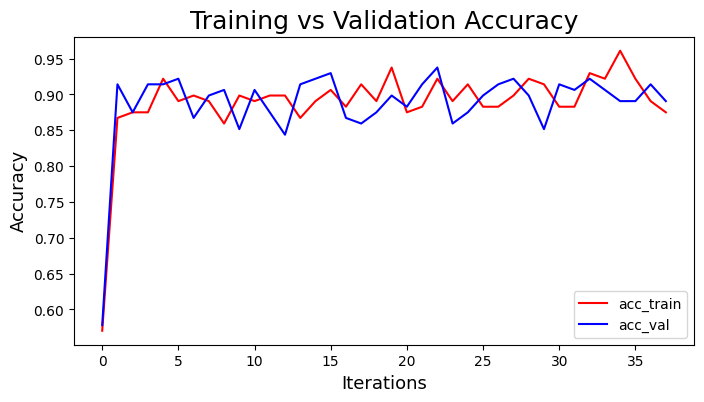

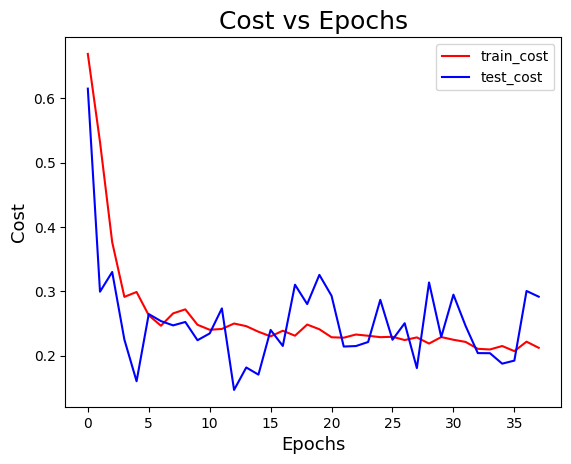

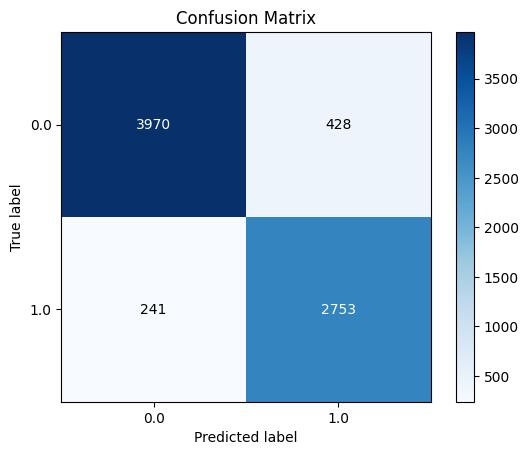

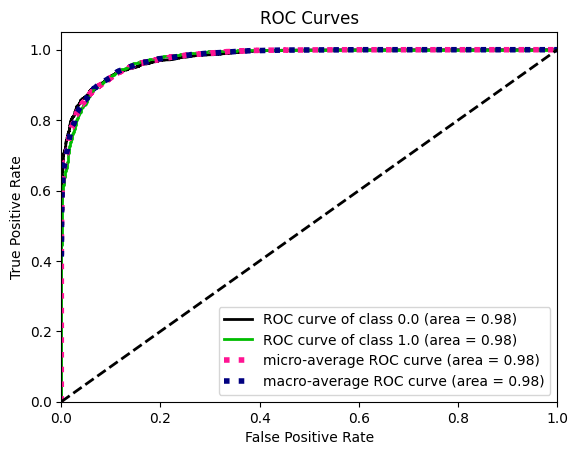

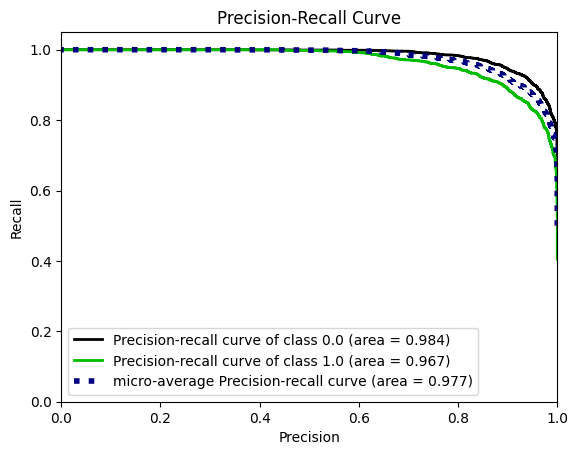

recall score: 0.9195
Precision score: 0.8655
F1 score: 0.8917
ROC_AUC score: 0.9763
Accuracy Score: 0.9095



In [ ]:
plot_history_acc(history)
plot_history_cost(history)
_ = eval_performance(net1, all_pred, all_true, all_proba, True)

#### Cross Validation

In [ ]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

all_acc = []
all_recall = []
all_precision = []
all_f1 = []
all_roc_score = []

all_train_acc = []
all_train_recall = []
all_train_precision = []
all_train_f1 = []
all_train_roc_score = []

# Iterate through each fold in KFold
for train_index, val_index in kfold.split(X_train):
  # initialize the network for each fold
  net = Net([184, 23, 72, 162, 166, 1])

  # Split data based on the current fold indices
  X_train_val, X_val = X.iloc[train_index], X.iloc[val_index]
  y_train_val, y_val = y.iloc[train_index], y.iloc[val_index]

  train_val_set = MyDataset(X_train_val, y_train_val)
  val_set = MyDataset(X_val, y_val)

  train_val_loader = DataLoader(train_val_set, batch_size=35, shuffle=True)
  val_loader = DataLoader(val_set, batch_size=35, shuffle=True)

  # Train your machine learning model here using X_train and y_train
  net.train()
  history = train(net, train_val_loader, val_loader, device, 38, lr=0.016321968204669322, momentum=0.8218190131143059)

  # Evaluate the model's performance on the training set (X_train_val, y_train_val)
  print("****************\n"+
        "Train performance:"+
        "\n****************")
  all_pred, all_true, all_proba = prediction(train_val_loader, net)
  train_acc, train_recall, train_precision, train_f1, train_roc_score = eval_performance(net, all_pred, all_true, all_proba)

  all_train_acc.append(train_acc)
  all_train_recall.append(train_recall)
  all_train_precision.append(train_precision)
  all_train_f1.append(train_f1)
  all_train_roc_score.append(train_roc_score)

  # and validation set (X_val, y_val)
  print("**********************\n"+
        "Validation performance:"+
        "\n**********************")
  all_pred, all_true, all_proba = prediction(val_loader, net)
  acc, recall, precision, f1, roc_score = eval_performance(net, all_pred, all_true, all_proba)

  all_acc.append(acc)
  all_recall.append(recall)
  all_precision.append(precision)
  all_f1.append(f1)
  all_roc_score.append(roc_score)

****************
Train performance:
****************
recall score: 0.8415
Precision score: 0.9315
F1 score: 0.8842
ROC_AUC score: 0.9792
Accuracy Score: 0.9121

**********************
Validation performance:
**********************
recall score: 0.7969
Precision score: 0.9217
F1 score: 0.8547
ROC_AUC score: 0.9638
Accuracy Score: 0.8945

****************
Train performance:
****************
recall score: 0.8836
Precision score: 0.9020
F1 score: 0.8927
ROC_AUC score: 0.9772
Accuracy Score: 0.9154

**********************
Validation performance:
**********************
recall score: 0.8780
Precision score: 0.8574
F1 score: 0.8676
ROC_AUC score: 0.9662
Accuracy Score: 0.8945

****************
Train performance:
****************
recall score: 0.8883
Precision score: 0.9084
F1 score: 0.8982
ROC_AUC score: 0.9788
Accuracy Score: 0.9199

**********************
Validation performance:
**********************
recall score: 0.8552
Precision score: 0.8857
F1 score: 0.8702
ROC_AUC score: 0.9677
Accurac

In [ ]:
# get the average of each metric for training and validation
print(f"\nAvg training accuracy: \t\t{sum(all_train_acc)/len(all_train_acc):.4f}")
print(f"Avg training recall: \t\t{sum(all_train_recall)/len(all_train_recall):.4f}")
print(f"Avg training precision: \t{sum(all_train_precision)/len(all_train_precision):.4f}")
print(f"Avg training f1: \t\t{sum(all_train_f1)/len(all_train_f1):.4f}")
print(f"Avg training ROC score: \t{sum(all_train_roc_score)/len(all_train_roc_score):.4f}")

print(f"\nAvg validation accuracy: \t{sum(all_acc)/len(all_acc):.4f}")
print(f"Avg validation recall: \t\t{sum(all_recall)/len(all_recall):.4f}")
print(f"Avg validation precision: \t{sum(all_precision)/len(all_precision):.4f}")
print(f"Avg validation f1: \t\t{sum(all_f1)/len(all_f1):.4f}")
print(f"Avg validation ROC score: \t{sum(all_roc_score)/len(all_roc_score):.4f}")


Avg training accuracy: 		0.9138
Avg training recall: 		0.8787
Avg training precision: 	0.9032
Avg training f1: 		0.8900
Avg training ROC score: 	0.9781

Avg validation accuracy: 	0.8965
Avg validation recall: 		0.8581
Avg validation precision: 	0.8809
Avg validation f1: 		0.8680
Avg validation ROC score: 	0.9663


#### Test Set Inference

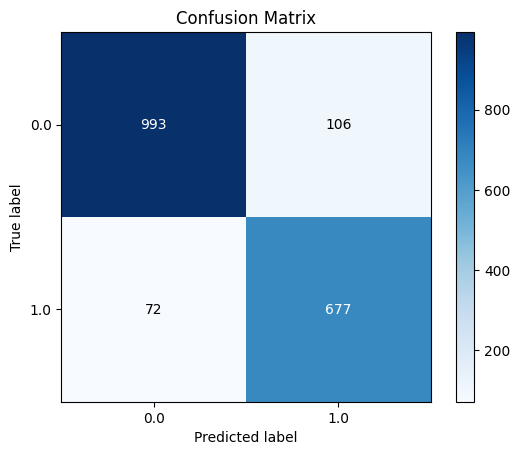

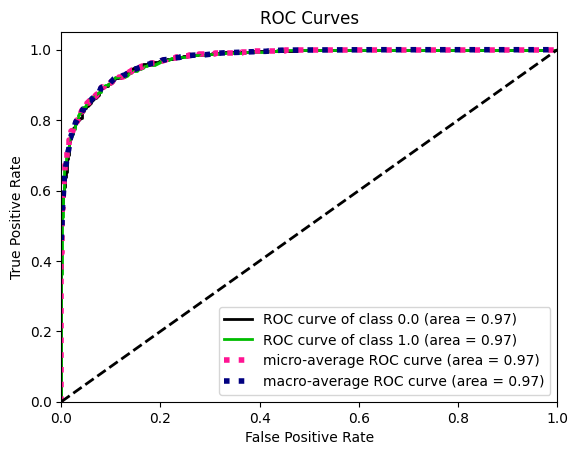

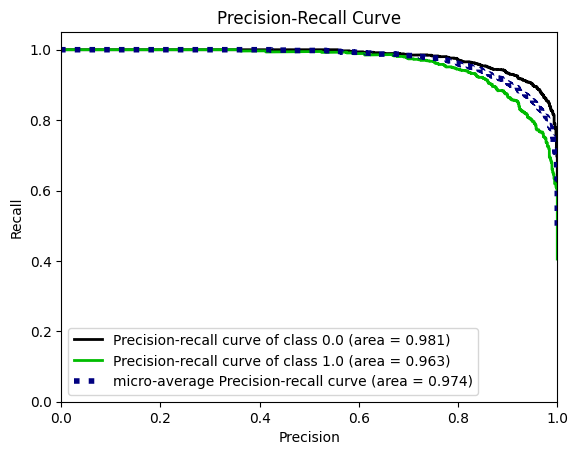

recall score: 0.9039
Precision score: 0.8646
F1 score: 0.8838
ROC_AUC score: 0.9721
Accuracy Score: 0.9037



In [ ]:
all_pred, all_true, all_proba = prediction(testloader, net1)
acc, recall, precision, f1, roc_score = eval_performance(net1, all_pred, all_true, all_proba, True)

#### Comparison between Train, Cross Val, Test Performance

In [ ]:
# Train set performance
'''
recall score: 0.9195
Precision score: 0.8655
F1 score: 0.8917
ROC_AUC score: 0.9763
Accuracy Score: 0.9095
'''

# Test set performance
'''
recall score: 0.9039
Precision score: 0.8646
F1 score: 0.8838
ROC_AUC score: 0.9721
Accuracy Score: 0.9037
'''

# Cross Val performance
'''
Avg training accuracy: 		0.9138
Avg training recall: 		0.8787
Avg training precision: 	0.9032
Avg training f1: 		0.8900
Avg training ROC score: 	0.9781

Avg validation accuracy: 	0.8965
Avg validation recall: 		0.8581
Avg validation precision: 	0.8809
Avg validation f1: 		0.8680
Avg validation ROC score: 	0.9663
'''

# Conclusion: training performance are slightly better than validation / testing, suspect model to have slightly overfitting issue

# comparison: less diff for each metric,

'\n\n'

In [ ]:
torch.save(net, "randopt.pt")

#### Test model with sample output

In [ ]:
net1.eval()
x_eval, y_eval = next(iter(testloader))
correct = 0
yhat = net1(x_eval)

ypred = yhat.ravel() >= 0.5

correct = (y_eval == ypred).double().sum()
acc = correct / len(y_eval)
print(acc)

tensor(0.9143, dtype=torch.float64)


In [ ]:
a = np.random.randint(0, X_test.shape[0])

X_test_np = X_test.iloc[a].to_numpy()
y_test_np = y_test.iloc[a]

input = torch.tensor(X_test_np, dtype=torch.float32)
output = torch.tensor(y_test_np, dtype=torch.float32)

y_score = net1(input)
y_pred = y_score.ravel() >= 0.5
print(f'output: {output}, y_pred: {y_pred}, y_score: {y_score}')

# if prediction == "0", then winner == "ct"
if y_pred:
  winner = "T"
else:
  winner = "CT"

print(f"The winner is {winner}")

output: 0.0, y_pred: tensor([False]), y_score: tensor([0.0019], grad_fn=<SigmoidBackward0>)
The winner is CT
